In [15]:
import os
import sys
from PIL import Image
from osgeo import gdal
import numpy as np
import rasterio
from osgeo import osr
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K

import glob
import os

import re
import datetime

from PIL import Image


import numpy as np
import pandas as pd
import geopandas as gpd

from sklearn.metrics import multilabel_confusion_matrix


from hyperopt import hp
from hyperopt import fmin, pyll, tpe, hp, STATUS_OK, Trials

import pickle
import time

import seaborn as sns

from matplotlib import pyplot as plt
from matplotlib.collections import PolyCollection
from mpl_toolkits.mplot3d import Axes3D
import imageio

In [2]:
#Load the model
model_improved = keras.models.load_model("17_model_improved")

In [3]:
# add here the folder path, where your  data is stored
directory = "E:/W_Katrin/Kigali/Raster/tiles"
files = glob.glob(os.path.join(directory,'*'))

pattern_img = '.*\.jpg'
# create a list of all images in that directory [after converting them to jpg with the code in Github README]
files_img = list(filter(re.compile(pattern_img).match,files))

files_img = sorted(files_img)

print('Image files: {}\n'.format(len(files_img)))

Image files: 1716



In [4]:
# create a dataframe of the satellite images and their respective mask 
df_files = pd.DataFrame(columns=['img'])
df_files['img'] = files_img


In [5]:
def make_test_gen(df_test,target_size,batch_size,seed):# this function generates augmented data[!not only training data!]
    # or better said: it generates a function which generates augmented data[generator function]
    
    # https://www.pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/
    # generate batches of tensor image data with real-time data augmentation 
    # batches of original training data are randomly transformed and then used for training (not the original data!)
  test_gen = keras.preprocessing.image.ImageDataGenerator()
    
    # read data from dataframe and perform powerful on-the-fly image augmentation with ImageDataGenerator
  test_generator = test_gen.flow_from_dataframe(
          dataframe=df_test,        
          x_col='img',
          target_size=target_size,
          batch_size=batch_size,
          seed = seed,
          class_mode=None,
          color_mode='rgb',
          shuffle=False)
  return test_generator


In [6]:
test_image_gen = make_test_gen(df_files, batch_size = 1,target_size = (256, 256), seed = 0) #seed 0 to keep the Reihenfolge
img_test = next(test_image_gen)
print(img_test.shape)

Found 1716 validated image filenames.
(1, 256, 256, 3)


In [7]:
# Generate output predictions for the input samples
mask_predicted = model_improved.predict(test_image_gen, verbose = 1)

1716/1716 [==============================] - 214s 125ms/step


In [8]:
# analyse mask predicted
print(mask_predicted.shape)
print(len(mask_predicted))

(1716, 256, 256, 3)
1716


In [9]:
#save predicted maps

savedir = "E:/W_Katrin/Kigali/Raster/tiles/predicted_m17_1"
for i in range(len(mask_predicted)): 
    mask_pred = np.squeeze(mask_predicted[i])
    #print(mask_pred)
    #print(mask_pred.dtype)
    mask_pred = (255*(mask_pred - np.min(mask_pred))/np.ptp(mask_pred)).astype("uint8")  
    #break
    padding = '0'
    len = 4
    save_to = os.path.join(savedir, "testing_{x}.jpg".format(x = format(i, padding + '>' + str(len))))
    imageio.imwrite(save_to, mask_pred)

In [50]:
# define function to display the results
def predict_buildings(img, mask_pred):
    i=0
    img=img[i].astype(int)
    mask_pred=np.squeeze(mask_pred[i])
    mask_pred_rend=np.argmax(mask_pred, axis=-1)
    plt.figure(figsize=0.8*np.array([3*6.4, 4.8]))
    plt.subplot(131) # = plt.subplot(1,3,1), 1 row, 4 columns,  first subplot (from right to left, first top row)
    plt.imshow(img)
    plt.subplot(132)
    plt.imshow(mask_pred)
    plt.subplot(133)
    plt.imshow(mask_pred_rend)
    plt.show()
    
    return mask_pred, mask_pred_rend

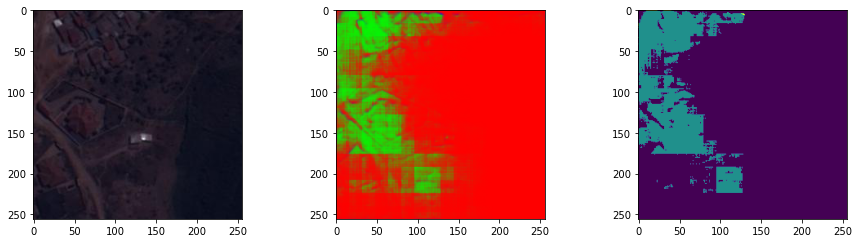

In [51]:
mask_predicted_, mask_predicted_rend_= predict_buildings(img_test, mask_predicted)

In [52]:
mask_predicted_rend_

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

# Put Images back together
### 1) zip testing and mask and put them together in a dataframe 
### 2) extract position from testing name 
### 3) somehow generate a mosaic

In [2]:
# add here the folder path, where your SpaceNet data is stored
directory_img = 'E:/W_Katrin/Kigali/Raster/tiles'


files = glob.glob(os.path.join(directory_img,'*'))
pattern_img = '.*\.jpg$'
files_img = list(filter(re.compile(pattern_img).match,files))
files_img = sorted(files_img)

directory_mask = "E:/W_Katrin/Kigali/Raster/tiles/predicted_m17_1"
files_ = glob.glob(os.path.join(directory_mask,'*'))
pattern_mask = '.*\.jpg$'
files_mask = list(filter(re.compile(pattern_mask).match,files_))
files_mask = sorted(files_mask)


In [3]:
# create a dataframe of the satellite images and their respective mask 
df_files = pd.DataFrame(columns=['img','mask', 'X', 'Y'])
df_files['img'] = files_img
df_files['mask'] = files_mask

In [9]:
img_test = Image.open(df_files["img"].iloc[3])
#print(img_test)
mask_predicted = Image.open(df_files["mask"].iloc[3])

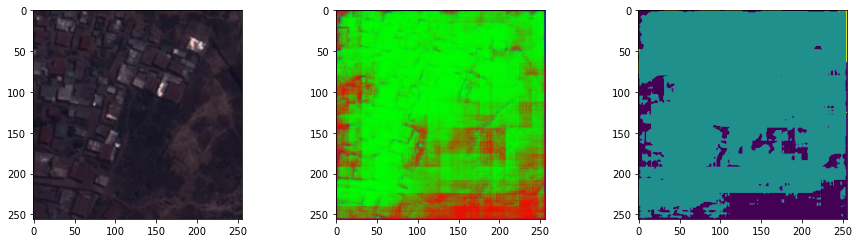

In [11]:
mask_pred=np.squeeze(mask_predicted)
mask_pred_rend=np.argmax(mask_pred, axis=-1)
plt.figure(figsize=0.8*np.array([3*6.4, 4.8]))
plt.subplot(131) # = plt.subplot(1,3,1), 1 row, 4 columns,  first subplot (from right to left, first top row)
plt.imshow(img_test)
plt.subplot(132)
plt.imshow(mask_pred)
plt.subplot(133)
plt.imshow(mask_pred_rend)
plt.show()

In [6]:
string = df_files["img"].iloc[0]
print(string)
string = string.split('/')[4].split('.')[0].split('_')
print(string)
x = string[1]
y = string[2]
print(x,y)
df_files['X'].iloc[0] = x
df_files['Y'].iloc[0] = y


E:/W_Katrin/Kigali/Raster/tiles\testing_00000_00000.jpg
['tiles\\testing', '00000', '00000']
00000 00000


In [7]:
for i in range(df_files.shape[0]): 
    string = df_files["img"].iloc[i]
    string = string.split('/')[4].split('.')[0].split('_')
    x = string[1]
    y = string[2]
    df_files['X'].iloc[i] = x
    df_files['Y'].iloc[i] = y

In [8]:
df_files

,img,mask,X,Y
0,E:/W_Katrin/Kigali/Raster/tiles\testing_00000_...,E:/W_Katrin/Kigali/Raster/tiles/predicted_m17_...,00000,00000
1,E:/W_Katrin/Kigali/Raster/tiles\testing_00000_...,E:/W_Katrin/Kigali/Raster/tiles/predicted_m17_...,00000,00256
2,E:/W_Katrin/Kigali/Raster/tiles\testing_00000_...,E:/W_Katrin/Kigali/Raster/tiles/predicted_m17_...,00000,00512
3,E:/W_Katrin/Kigali/Raster/tiles\testing_00000_...,E:/W_Katrin/Kigali/Raster/tiles/predicted_m17_...,00000,00768
4,E:/W_Katrin/Kigali/Raster/tiles\testing_00000_...,E:/W_Katrin/Kigali/Raster/tiles/predicted_m17_...,00000,01024
...,...,...,...,...
1711,E:/W_Katrin/Kigali/Raster/tiles\testing_13056_...,E:/W_Katrin/Kigali/Raster/tiles/predicted_m17_...,13056,07168
1712,E:/W_Katrin/Kigali/Raster/tiles\testing_13056_...,E:/W_Katrin/Kigali/Raster/tiles/predicted_m17_...,13056,07424
1713,E:/W_Katrin/Kigali/Raster/tiles\testing_13056_...,E:/W_Katrin/Kigali/Raster/tiles/predicted_m17_...,13056,07680
1714,E:/W_Katrin/Kigali/Raster/tiles\testing_13056_...,E:/W_Katrin/Kigali/Raster/tiles/predicted_m17_...,13056,07936


## Mosaic ---- NOTHING WORKS YET!!
1) Load Mask files
2) Get Coordinates of original file's upper left corner (---> point) 
2) Loop through mask files, create world files for each mask file by: 
    georef_x + (0.4*X)
    georef_y + (0.4*Y)
    save in World-File for each mask_tile
3) Merge / Mosaic 

In [77]:
pt_file = "E:/W_Katrin/Kigali/Raster/2015_Pleiades_Kigali_subset_ReferencePointUL.shp"
point = gpd.read_file(pt_file)
x_coord = point["geometry"].x[0]
print(point["geometry"])
y_coord = point["geometry"].y[0]
x_coord, y_coord

0    POINT (173723.362 9789230.702)
Name: geometry, dtype: geometry


(173723.36172185623, 9789230.701895246)

In [60]:
res = 0.4963 # in meters

In [29]:
df_files["mask"].head()

0    E:/W_Katrin/Kigali/Raster/tiles/predicted_m17_...
1    E:/W_Katrin/Kigali/Raster/tiles/predicted_m17_...
2    E:/W_Katrin/Kigali/Raster/tiles/predicted_m17_...
3    E:/W_Katrin/Kigali/Raster/tiles/predicted_m17_...
4    E:/W_Katrin/Kigali/Raster/tiles/predicted_m17_...
Name: mask, dtype: object

In [58]:
mask = df_files["mask"].iloc[0].split('\\')[1].split('.')[0]
print(mask)
directory = df_files["mask"].iloc[0].split('\\')[0]
print(directory)
os.path.join(directory, mask +'.jgw')

testing_0000
E:/W_Katrin/Kigali/Raster/tiles/predicted_m17_1


'E:/W_Katrin/Kigali/Raster/tiles/predicted_m17_1\\testing_0000.jgw'

In [88]:
f = open(os.path.join(directory,'test.jgw'), "w")
f.write('{pixel_size}\n'.format(pixel_size = res))
f.write('0.0\n') #rotation
f.write('0.0\n') #rotation
f.write('{easting}\n'.format(easting = (x_coord + (res*int(df_files["X"].iloc[1])))))
f.write('{northing}\n'.format(northing = (y_coord + (res*int(df_files["Y"].iloc[1])))))

18

In [83]:
type(int(df_files["X"].iloc[0]))

int

In [109]:
def create_worldfiles(dataframe, res, point_path):
    point = gpd.read_file(point_path)
    x_coord = point["geometry"].x[0]
    y_coord = point["geometry"].y[0]
    for i in range(len(dataframe)): 
        directory = dataframe["mask"].iloc[i].split('\\')[0]
        mask_str = dataframe["mask"].iloc[i].split('\\')[1].split('.')[0]
        f = open(os.path.join(directory, mask_str + '.jgw'), "w")
        f.write('{pixel_size}\n'.format(pixel_size = res)) #pixel size x
        f.write('{pixel_size}\n'.format(pixel_size = res)) #pixel size y
        f.write('0.0\n') #rotation
        f.write('0.0\n') #rotation
        f.write('{easting}\n'.format(easting = (x_coord + (res*int(dataframe["X"].iloc[i]))))) #location x
        f.write('{northing}\n'.format(northing = (y_coord + (res*int(dataframe["Y"].iloc[i])))))#location y
        f.close()  

In [110]:
pt_file = "E:/W_Katrin/Kigali/Raster/2015_Pleiades_Kigali_subset_ReferencePointUL.shp"
create_worldfiles(dataframe = df_files, res =  0.4963, point_path = pt_file)